Cosmology calculator

In [1]:
from dataclasses import dataclass
import numpy as np
from astropy import units as u,constants as c
from astropy.visualization import quantity_support
quantity_support()
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.integrate import quad
from scipy.optimize import bisect

In [2]:
@dataclass
class Cosmology:
    """Cosmology calculator

    Calculates cosmological parameters as functions of redshift
    given the cosmological parameters at z=0

    All the outputs and hubble constant input should be in astropy.units

    Args:
            omega_m_0: float = 0.315
            omega_lambda_0: float = 0.685
            omega_rad_0: float = 8e-5
            hubble_0: u.km/u.s/u.Mpc = 70 * u.km/u.s/u.Mpc
    """
    omega_m_0: float = 0.315
    omega_lambda_0: float = 0.685
    omega_rad_0: float = 8e-5
    hubble_0: u.km/u.s/u.Mpc = 70 * u.km/u.s/u.Mpc

    def __post_init__(self):
        self.hubble_0 = self.hubble_0.to(u.km/u.s/u.Mpc)

    @property
    def omega_k_0(self):
        return 1-self.omega_m_0-self.omega_lambda_0-self.omega_rad_0

    def _e(self, z):
        return np.sqrt(self.omega_rad_0*(1+z)**4 +
                       self.omega_m_0*(1+z)**3 +
                       self.omega_k_0*(1+z)**2 +
                       self.omega_lambda_0)

    def _g(self, z):
        return 2.5 * self.omega_m(z) / (
                self.omega_m(z)**(4./7) - self.omega_lambda(z)
                +(1+0.5*self.omega_m(z))*(1+self.omega_lambda(z)/70)
        )

    def d_plus(self, z):
        return 1/(1+z) * self._g(z)/self._g(0)

    def hubble_factor(self, z):
        return self.hubble_0 * self._e(z)

    def omega_m(self, z):
        return self.omega_m_0 * (1+z)**3 / self._e(z)**2

    def omega_rad(self, z):
        return self.omega_rad_0 * (1+z)**4/self._e(z)**2

    def omega_lambda(self, z):
        return self.omega_lambda_0/self._e(z)**2

    def omega_k(self, z):
        return self.omega_k_0*(1+z)**2/self._e(z)**2

    def rho_crit(self, z):
        return 3*self.hubble_factor(z)/(8*np.pi*c.G)

    def physical_distance(self, z):
        return 1/(1+z) * self.comoving_distance(z)

    def comoving_distance(self, z):
        try:
            return u.Mpc * quad(lambda zz: c.c/self.hubble_factor(zz)/u.Mpc, 0, z)[0]
        except ValueError:
            return u.Mpc * np.array([quad(lambda zz: c.c/self.hubble_factor(zz)/u.Mpc, 0, zzz)[0] for zzz in z])

    def cosmic_time(self,z):
        try:
            return self.hubble_time * quad(lambda zz: 1/((1+zz)*self._e(zz)), z, np.inf)[0]
        except ValueError:
            return self.hubble_time * np.array([quad(lambda zz: 1/((1+zz)*self._e(zz)), zzz, np.inf)[0] for zzz in z])

    def a(self,z):
        return 1/(1+z)

    def __repr__(self):
        return (f"Cosmology calculator\n"
                f"Parameters at z=0:\n"
                f"Hubble constant = {self.hubble_0}\n"
                f"Omega M = {self.omega_m_0}\n"
                f"Omega Lam = {self.omega_lambda_0}\n"
                f"Omega R = {self.omega_rad_0}\n"
        )

    def recombination(self, zmin=1e-3, zmax=1e4):
        try:
            return bisect(lambda z: self.omega_m(z)-self.omega_rad(z), zmin, zmax)
        except ValueError:
            return None

    def darkenergy(self, zmin=1e-3, zmax=1e4):
        try:
            return bisect(lambda z: self.omega_m(z)-self.omega_lambda(z), zmin, zmax)
        except ValueError:
            return None

    @property
    def hubble_time(self):
        return (1/self.hubble_0).to(u.Gyr)

    def report(self, show=True, zmin = 1e-3, zmax=1e4, nz=100):
        print(self)
        z = np.array([*np.geomspace(zmax,zmin,nz),0])
        ax = plt.subplot()
        ax.loglog(z, self.hubble_factor(z))
        ax.set_xlabel("z")
        ax.set_title("Hubble")
        if show: plt.show()

        ax = plt.subplot()
        ax.semilogx(z, self.omega_rad(z), label="Omega R")
        ax.semilogx(z, self.omega_m(z), label="Omega M")
        ax.semilogx(z, self.omega_lambda(z), label="Omega Lambda")
        ax.semilogx(z, self.omega_k(z), label="Omega K")
        rec = self.recombination()
        if rec:
            print(f"Matter-radiation equality time: {self.cosmic_time(rec)}")
            ax.axvline(rec, label="Matter-radiation equality", color='k', linestyle="-.")
        de = self.darkenergy()
        if de:
            print(f"DE domination time: {self.cosmic_time(de)}")
            ax.axvline(self.darkenergy(), label="DE domination", color='k', linestyle="--")
        ax.legend(loc=1)
        ax.set_xlabel("z")
        ax.set_ylim(-0.1,1.1)
        ax.set_title("Omega")
        if show: plt.show()

        ax = plt.subplot()
        ax.loglog(z, self.comoving_distance(z))
        ax.set_xlabel("z")
        ax.set_title("Comoving distance")
        if show: plt.show()

        ax = plt.subplot()
        ax.loglog(z, self.physical_distance(z))
        ax.set_xlabel("z")
        ax.set_title("Physical distance")
        if show: plt.show()

        ax = plt.subplot()
        ax.loglog(z, self.cosmic_time(z))
        ax.set_xlabel("z")
        ax.set_title("Universe age")
        print(f"Universe age: {self.cosmic_time(0)}")
        if show: plt.show()

        ax = plt.subplot()
        ax.loglog(self.cosmic_time(z), self.a(z))
        ax.set_title("Scale factor")
        if show: plt.show()

        ax = plt.subplot()
        ax.loglog(z, self.d_plus(z))
        ax.set_xlabel("z")
        ax.set_title("D+")
        if show: plt.show()

Cosmology calculator
Parameters at z=0:
Hubble constant = 70.0 km / (Mpc s)
Omega M = 0.315
Omega Lam = 0.685
Omega R = 8e-05

Matter-radiation equality time: 3.933783809627831e-05 Gyr
DE domination time: 9.912534975476966 Gyr
Universe age: 13.279480194034004 Gyr


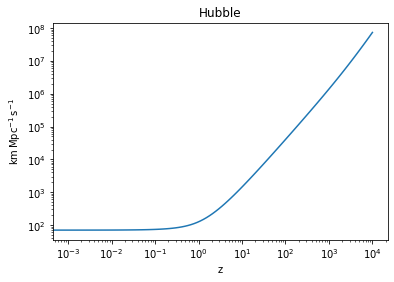

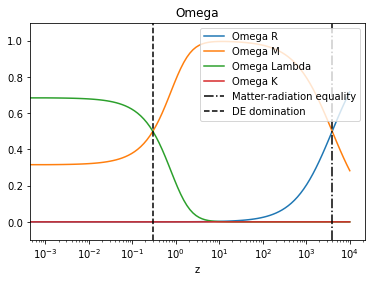

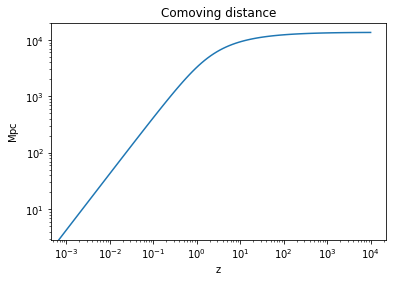

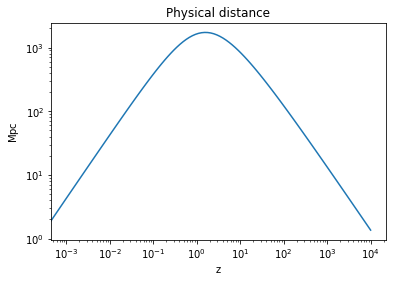

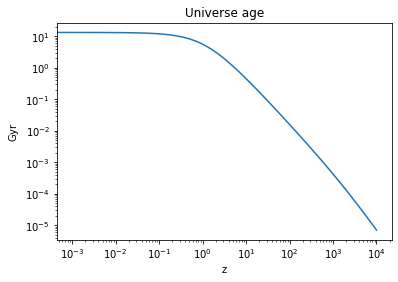

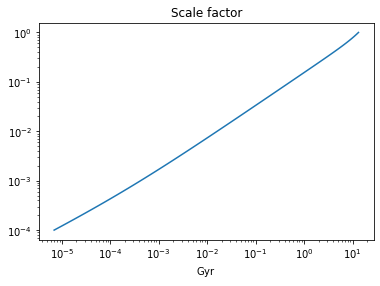

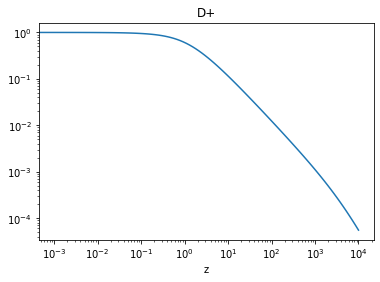

In [3]:
# Planck universe
Cosmology().report()

Cosmology calculator
Parameters at z=0:
Hubble constant = 70.0 km / (Mpc s)
Omega M = 1
Omega Lam = 0
Omega R = 0

Universe age: 9.312306873077414 Gyr


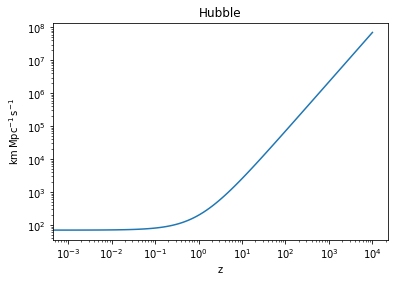

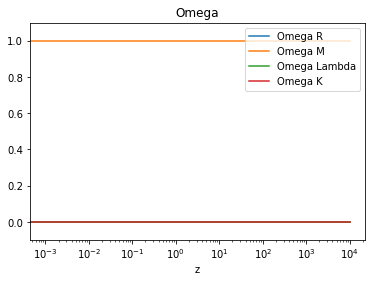

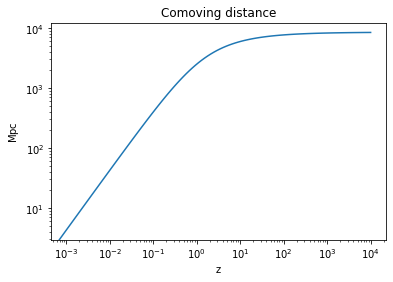

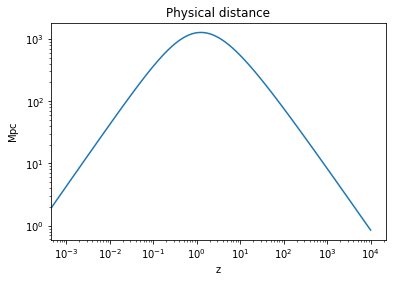

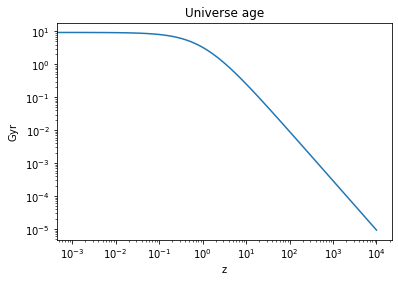

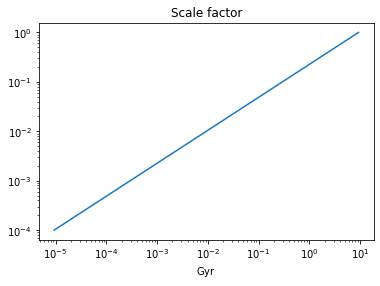

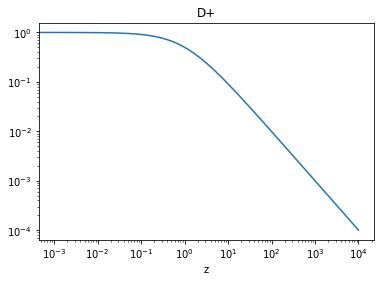

In [4]:
# Mass-only universe
Cosmology(omega_m_0=1, omega_lambda_0=0, omega_rad_0=0).report()

Cosmology calculator
Parameters at z=0:
Hubble constant = 70.0 km / (Mpc s)
Omega M = 0.3
Omega Lam = 0.7
Omega R = 0

DE domination time: 9.809983806863066 Gyr
Universe age: 13.466983946956367 Gyr


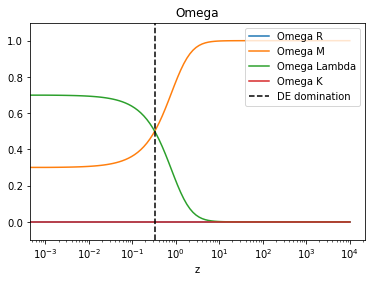

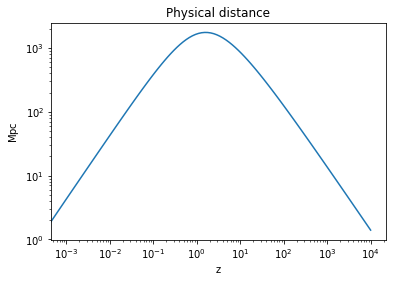

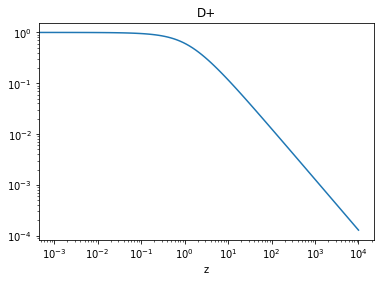

In [5]:
# Radiation-free universe
Cosmology(omega_m_0=0.3, omega_lambda_0=0.7, omega_rad_0=0).report()

Cosmology calculator
Parameters at z=0:
Hubble constant = 70.0 km / (Mpc s)
Omega M = 0.3
Omega Lam = 0.7
Omega R = 0.08

Matter-radiation equality time: 1.3795526497491568 Gyr
DE domination time: 7.9039032066393995 Gyr
Universe age: 11.50506953676238 Gyr


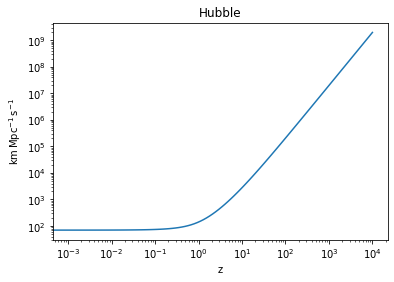

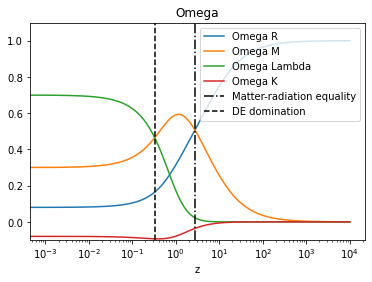

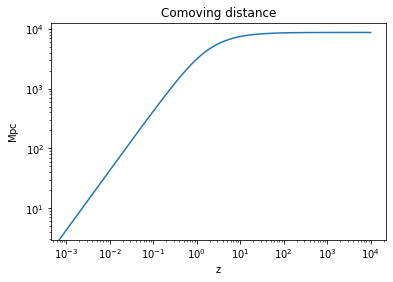

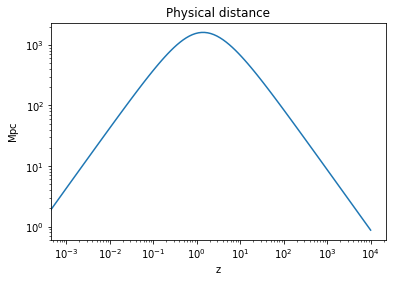

<ipython-input-2-0fafb2cf8293>:74: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return self.hubble_time * np.array([quad(lambda zz: 1/((1+zz)*self._e(zz)), zzz, np.inf)[0] for zzz in z])
<ipython-input-2-0fafb2cf8293>:74: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return self.hubble_time * np.array([quad(lambda zz: 1/((1+zz)*self._e(zz)), zzz, np.inf)[0] for zzz in z])


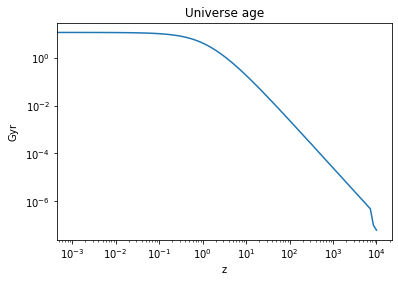

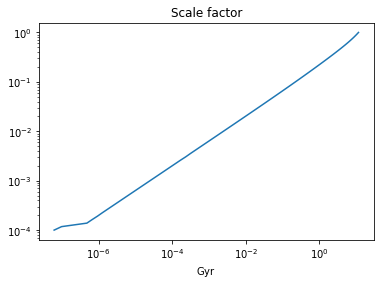

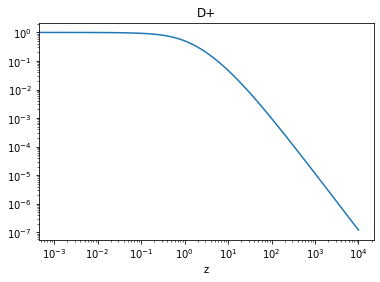

In [6]:
# Radiation-rich universe
Cosmology(omega_m_0=0.3, omega_lambda_0=0.7, omega_rad_0=8e-2).report()

Cosmology calculator
Parameters at z=0:
Hubble constant = 70.0 km / (Mpc s)
Omega M = 0.3
Omega Lam = 0
Omega R = 0.08

Matter-radiation equality time: 1.2818755297207867 Gyr
Universe age: 10.020060275077423 Gyr


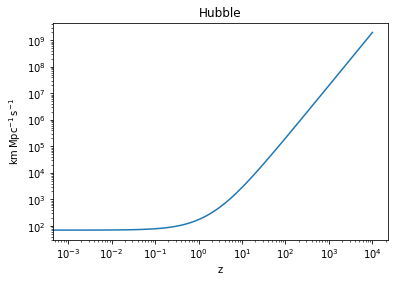

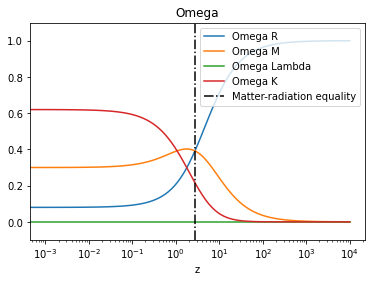

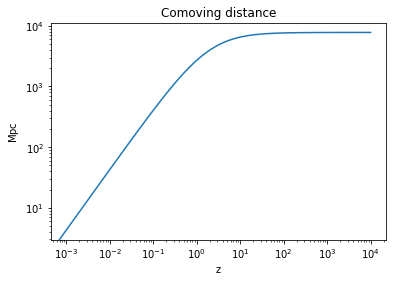

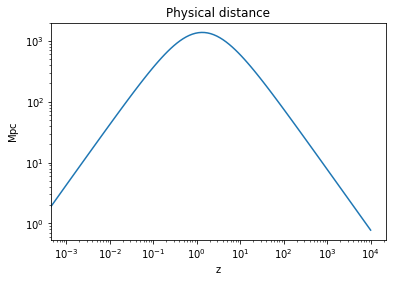

<ipython-input-2-0fafb2cf8293>:74: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return self.hubble_time * np.array([quad(lambda zz: 1/((1+zz)*self._e(zz)), zzz, np.inf)[0] for zzz in z])
<ipython-input-2-0fafb2cf8293>:74: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return self.hubble_time * np.array([quad(lambda zz: 1/((1+zz)*self._e(zz)), zzz, np.inf)[0] for zzz in z])


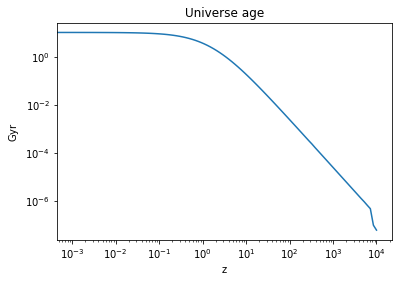

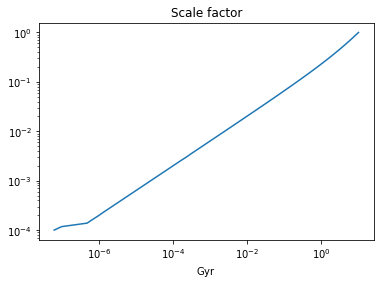

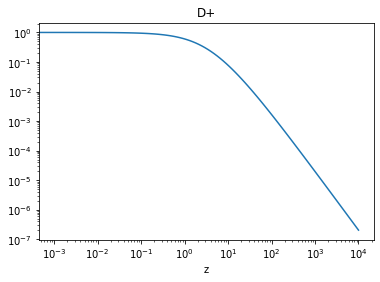

In [7]:
# Low-density universe
Cosmology(omega_m_0=0.3, omega_lambda_0=0, omega_rad_0=8e-2).report()

Low density : Cosmology calculator
Parameters at z=0:
Hubble constant = 70.0 km / (Mpc s)
Omega M = 0.3
Omega Lam = 0
Omega R = 0

Mass only : Cosmology calculator
Parameters at z=0:
Hubble constant = 70.0 km / (Mpc s)
Omega M = 1
Omega Lam = 0
Omega R = 0

Planck : Cosmology calculator
Parameters at z=0:
Hubble constant = 70.0 km / (Mpc s)
Omega M = 0.315
Omega Lam = 0.685
Omega R = 8e-05



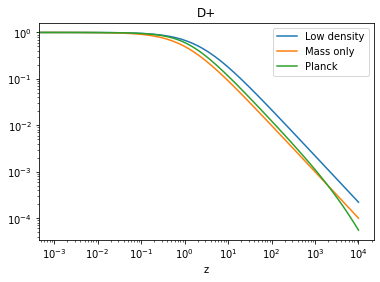

In [8]:
low_dens = Cosmology(omega_m_0=0.3, omega_lambda_0=0, omega_rad_0=0)
mass_only = Cosmology(omega_m_0=1, omega_lambda_0=0, omega_rad_0=0)
planck = Cosmology()

cosmologies = {"Low density": low_dens,
               "Mass only": mass_only,
               "Planck": planck}

z = np.array([*np.geomspace(1e4,1e-3,100),0])

ax = plt.subplot()
for key, cosmology in cosmologies.items():
    ax.loglog(z, cosmology.d_plus(z), label=key)
    print(f"{key} : {cosmology}")
ax.set_xlabel("z")
ax.set_title("D+")
plt.legend()
plt.show()
